In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import os
import sys

import dotenv

# Load environment variables
dotenv.load_dotenv()

# Enable loading of the project module
MODULE_DIR = os.path.join(os.path.abspath(os.path.join(os.path.curdir, os.path.pardir)), "src")
sys.path.append(MODULE_DIR)


In [3]:
import pathlib
import torch
import matplotlib.pyplot as plt
import sklearn.metrics
import numpy as np
import os
import sklearn.linear_model
import sklearn.model_selection
import tqdm.notebook
import multiprocessing
import typing

import attack_util
import data

In [4]:
BASE_DIR = pathlib.Path(...)  # TODO: HAMP experiment base dir
DATA_DIR = pathlib.Path(os.environ["DATA_ROOT"]).expanduser().resolve()
CANARY_TYPES = (
    "clean",
    "label_noise",
)
NUM_SHADOW = 64
NUM_CANARIES = 500
NUM_POISON = 0
POISON_TYPE = data.PoisonType.RANDOM_IMAGES
SEED = 0
NUM_HPS = 5

# Tune for all settings

In [5]:
C_VALS = np.logspace(-3, 2, 11, dtype=attack_util.LIRA_DTYPE_NUMPY)
TARGET_FPR = 0.001


In [6]:
class _LogRegCVRunner(typing.Callable):
    def __init__(
        self,
        all_targets: np.ndarray,
        all_features: np.ndarray,
        target_model_idx: int,
    ):
        self.all_targets = all_targets
        self.all_features = all_features
        self.target_model_idx = target_model_idx
    
    def __call__(self, sample_idx: int) -> np.ndarray:
        # ys are membership
        current_ys = np.delete(self.all_targets[sample_idx], self.target_model_idx, axis=0)
        
        # xs are correct predictions over data augmentations
        current_xs = np.delete(self.all_features[sample_idx], self.target_model_idx, axis=0)
        target_x = self.all_features[sample_idx, self.target_model_idx].reshape(1, -1)
        
        current_preds = np.zeros_like(C_VALS)
        
        for C_idx, C in enumerate(C_VALS):
            regressor = sklearn.linear_model.LogisticRegression(
                C=C,
                penalty="l2",
                random_state=SEED,
                warm_start=False,
                max_iter=1000,
            )
            regressor.fit(current_xs, current_ys)
            assert regressor.classes_.shape == (2,)
            assert regressor.classes_[0] == 0 and regressor.classes_[1] == 1
            
            target_pred_prob = regressor.predict_proba(target_x)[0, 1]  # "first sample", IN
            current_preds[C_idx] = target_pred_prob
        
        return current_preds


Tuning for clean, HP set 0


Cross-validation: 100%|██████████| 64/64 [01:20<00:00,  1.25s/splits]


Best TPR@0.1% FPR 8.21% for C=0.31622776601683794
TPR@0.1% FPR 7.12% for default C=1.0


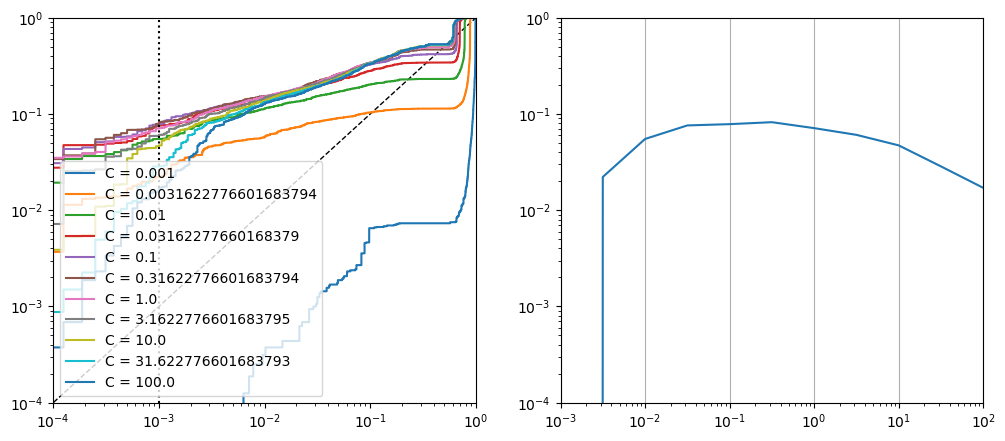


Tuning for clean, HP set 1


Cross-validation: 100%|██████████| 64/64 [01:18<00:00,  1.22s/splits]


Best TPR@0.1% FPR 6.41% for C=1.0
TPR@0.1% FPR 6.41% for default C=1.0


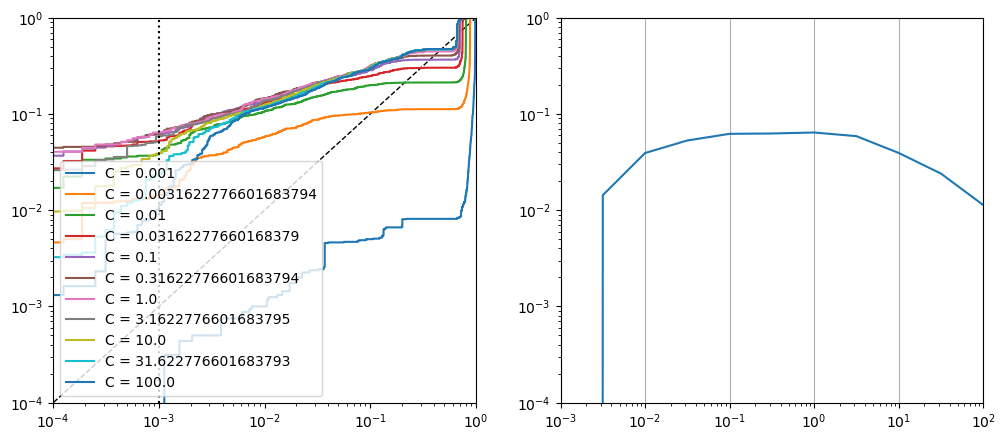


Tuning for clean, HP set 2


Cross-validation: 100%|██████████| 64/64 [01:23<00:00,  1.30s/splits]


Best TPR@0.1% FPR 8.08% for C=0.31622776601683794
TPR@0.1% FPR 7.69% for default C=1.0


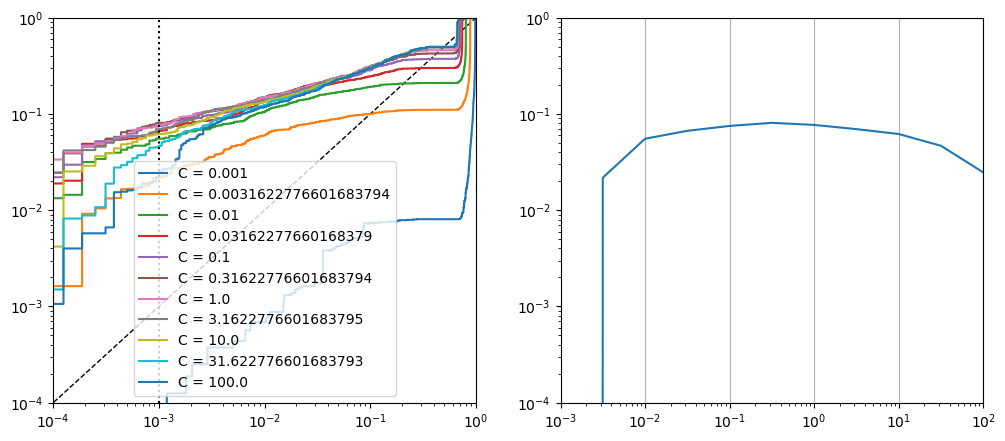


Tuning for clean, HP set 3


Cross-validation: 100%|██████████| 64/64 [01:25<00:00,  1.34s/splits]


Best TPR@0.1% FPR 4.25% for C=0.1
TPR@0.1% FPR 3.04% for default C=1.0


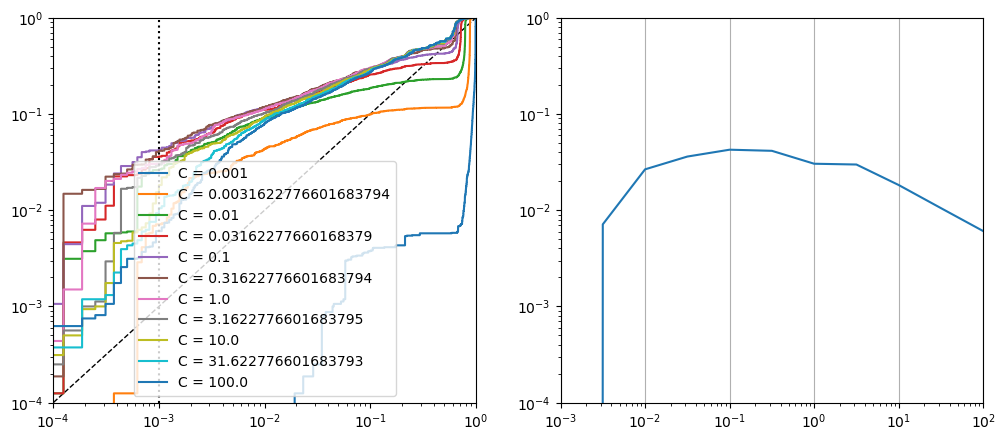


Tuning for clean, HP set 4


Cross-validation: 100%|██████████| 64/64 [01:28<00:00,  1.38s/splits]


Best TPR@0.1% FPR 3.34% for C=1.0
TPR@0.1% FPR 3.34% for default C=1.0


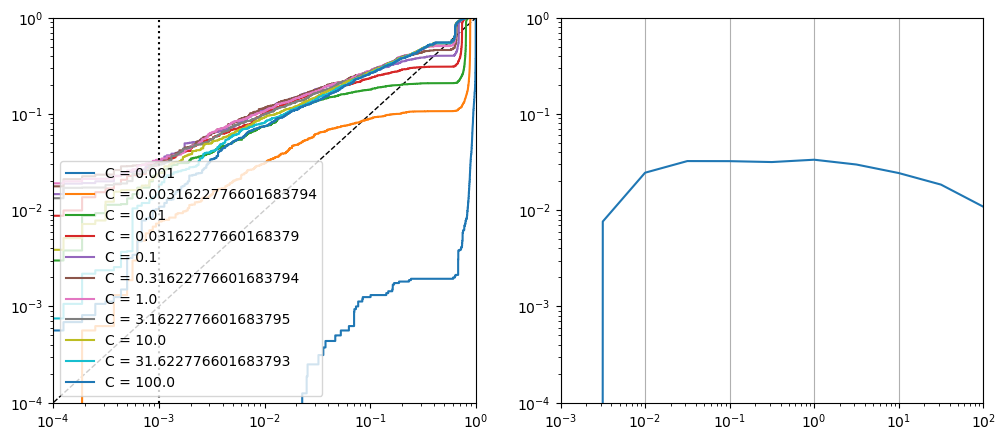


Tuning for label_noise, HP set 0


Cross-validation: 100%|██████████| 64/64 [00:58<00:00,  1.09splits/s]


Best TPR@0.1% FPR 96.96% for C=100.0
TPR@0.1% FPR 95.33% for default C=1.0


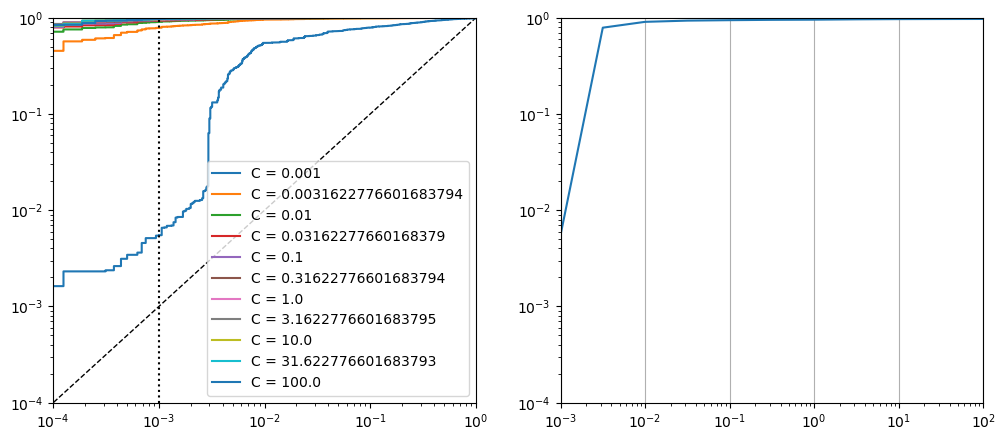


Tuning for label_noise, HP set 1


Cross-validation: 100%|██████████| 64/64 [00:56<00:00,  1.14splits/s]


Best TPR@0.1% FPR 61.28% for C=1.0
TPR@0.1% FPR 61.28% for default C=1.0


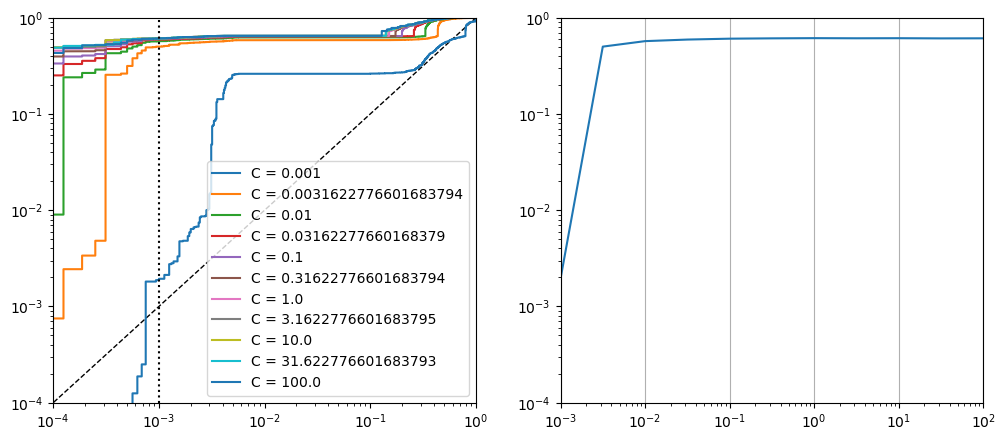


Tuning for label_noise, HP set 2


Cross-validation: 100%|██████████| 64/64 [00:57<00:00,  1.12splits/s]


Best TPR@0.1% FPR 85.60% for C=31.622776601683793
TPR@0.1% FPR 81.04% for default C=1.0


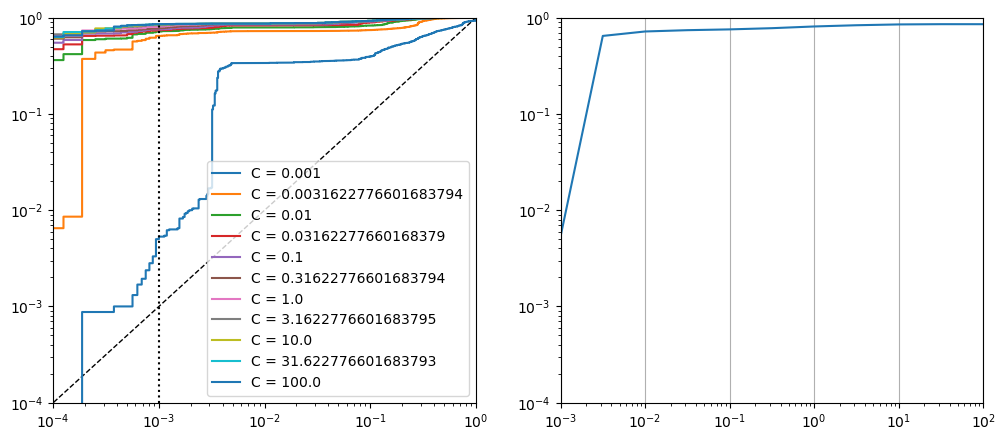


Tuning for label_noise, HP set 3


Cross-validation: 100%|██████████| 64/64 [00:57<00:00,  1.12splits/s]


Best TPR@0.1% FPR 52.14% for C=3.1622776601683795
TPR@0.1% FPR 51.48% for default C=1.0


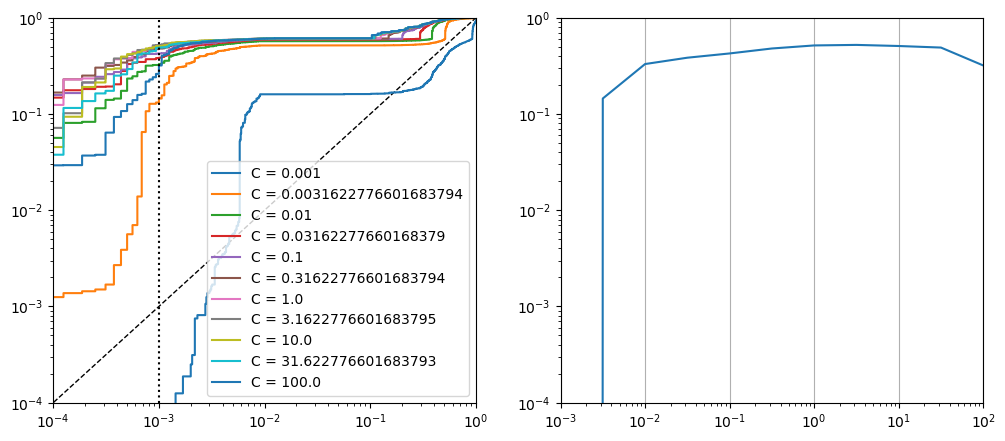


Tuning for label_noise, HP set 4


Cross-validation: 100%|██████████| 64/64 [00:52<00:00,  1.22splits/s]


Best TPR@0.1% FPR 29.23% for C=10.0
TPR@0.1% FPR 28.48% for default C=1.0


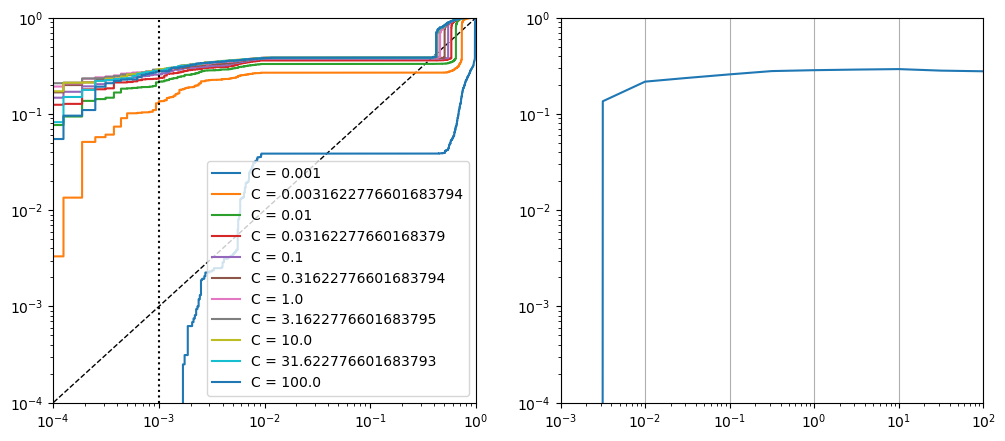

In [7]:
for canary_idx in range(len(CANARY_TYPES)):
    for hp_idx in range(NUM_HPS):
        print(f"Tuning for {CANARY_TYPES[canary_idx]}, HP set {hp_idx}")

        current_run_dir = BASE_DIR / CANARY_TYPES[canary_idx] / f"shadow_train_{hp_idx}"
        current_logits_raw = []
        try:
            for shadow_model_idx in range(NUM_SHADOW):
                current_logits_raw.append(
                    torch.load(
                        current_run_dir / str(shadow_model_idx) / "predictions_train_testtime.pt"
                    ).to(dtype=attack_util.LIRA_DTYPE_TORCH).numpy().astype(attack_util.LIRA_DTYPE_NUMPY)
                )
            
            current_logits = np.stack(current_logits_raw, axis=1)
            _, _, num_aug, num_classes = current_logits.shape
        except Exception as ex:
            print("Could not load all logits, skipping. Exception:", ex)
            continue
        
        data_generator = data.DatasetGenerator(
            num_shadow=NUM_SHADOW,
            num_canaries=NUM_CANARIES,
            canary_type=data.CanaryType(CANARY_TYPES[canary_idx]),
            num_poison=NUM_POISON,
            poison_type=POISON_TYPE,
            data_dir=DATA_DIR,
            seed=SEED,
            download=False,
        )
        
        attack_ys, shadow_membership_mask, canary_indices = data_generator.build_attack_data()
        true_labels = attack_ys[canary_indices].numpy()
        all_targets = shadow_membership_mask[canary_indices].numpy().astype(int)
        all_features = (current_logits[canary_indices].argmax(-1) == true_labels.reshape(-1, 1, 1)).astype(
            attack_util.LIRA_DTYPE_NUMPY
        )
        num_samples = all_features.shape[0]
        
        # Leave one out
        cv_preds = np.empty((NUM_SHADOW, num_samples, len(C_VALS)), dtype=attack_util.LIRA_DTYPE_NUMPY)
        with multiprocessing.Pool(16) as pool:
            for target_model_idx in tqdm.trange(NUM_SHADOW, desc="Cross-validation", unit="splits"):
                runner = _LogRegCVRunner(
                    all_targets=all_targets,
                    all_features=all_features,
                    target_model_idx=target_model_idx,
                )
                for sample_idx, current_preds in enumerate(pool.imap(runner, range(num_samples), chunksize=16)):
                    cv_preds[target_model_idx, sample_idx] = current_preds
        
        fig, (ax_roc, ax_tprs) = plt.subplots(1, 2, figsize=(2 * 6, 5))
        
        membership = all_targets.flatten()
        all_scores = np.transpose(cv_preds, axes=(2, 1, 0)).copy()
        
        ax_roc.plot((0, 1), (0, 1), c="k", ls="dashed", lw=1)
        tprs_at_fpr = np.zeros_like(C_VALS)
        for C_idx, C in enumerate(C_VALS):
            current_scores = all_scores[C_idx].flatten()
            assert current_scores.shape == membership.shape
            fpr, tpr, _ = sklearn.metrics.roc_curve(
                y_true=membership,
                y_score=current_scores,
            )
            ax_roc.plot(fpr, tpr, c=f"C{C_idx}", label=f"C = {C}")
            tprs_at_fpr[C_idx] = max(tpr[fpr <= TARGET_FPR])
        
        ax_roc.axvline(TARGET_FPR, c="k", ls="dotted")
        ax_roc.loglog()
        ax_roc.set_xlim(1e-4, 1)
        ax_roc.set_ylim(1e-4, 1)
        ax_roc.legend()
        
        ax_tprs.plot(C_VALS, tprs_at_fpr)
        ax_tprs.set_xlim(min(C_VALS), max(C_VALS))
        ax_tprs.set_ylim(1e-4, 1)
        ax_tprs.set_xticks([], minor=True)
        ax_tprs.set_xticks(C_VALS, labels=C_VALS)
        ax_tprs.grid(visible=True, which="major", axis="x")
        ax_tprs.loglog()
        
        best_C_idx = np.argmax(tprs_at_fpr)
        default_C_idx = np.argwhere(C_VALS == 1.0)[0, 0]
        print(f"Best TPR@0.1% FPR {tprs_at_fpr[best_C_idx]*100:.2f}% for C={C_VALS[best_C_idx]}")
        print(f"TPR@0.1% FPR {tprs_at_fpr[default_C_idx]*100:.2f}% for default C={C_VALS[default_C_idx]}")
        
        plt.show()
        plt.close(fig)
        print()
